In [28]:
from huggingface_hub import hf_hub_download

hf_hub_download(repo_id="eastwind/gpt2-audio-tiny-sherlock-100k-overfit", filename="log.txt", local_dir='./pretrained')
hf_hub_download(repo_id="eastwind/gpt2-audio-tiny-sherlock-100k-overfit", filename="model_56000.pt", local_dir='./pretrained')

log.txt:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

model_56000.pt:   0%|          | 0.00/397M [00:00<?, ?B/s]

'./pretrained/model_56000.pt'

In [29]:
val = 'validation'
train = 'train'

with open('./pretrained/log.txt') as f:
    log = [[eval(y) for y in x.strip().split(' ')] for x in f.readlines()]

In [30]:
val_x = [x[0] for x in log if x[1] == val]
val_y = [x[-1] for x in log if x[1] == val]

train_x = [x[0] for x in log if x[1] == train]
train_y = [x[-1] for x in log if x[1] == train]

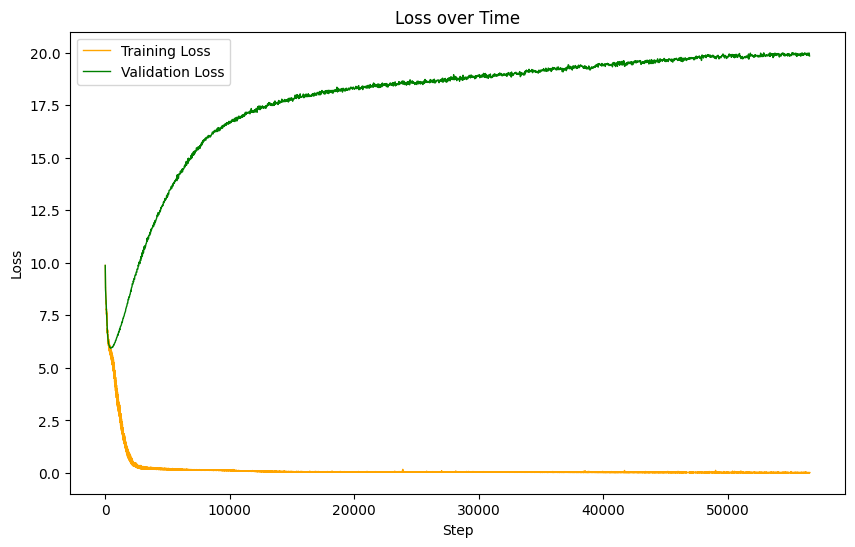

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the provided image for validation and training sets
val_data = {
    "step": val_x,
    "loss": val_y
}

train_data = {
    "step": train_x,
    "loss": train_y
}

# Create DataFrames
val_df = pd.DataFrame(val_data)
train_df = pd.DataFrame(train_data)

# Plotting step vs loss for both validation and training sets
plt.figure(figsize=(10, 6))
plt.plot(train_df['step'], train_df['loss'], label='Training Loss', color='orange', linewidth=1)
plt.plot(val_df['step'], val_df['loss'], label='Validation Loss', color='green', linewidth=1)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss over Time')
# plt.xlim([0, 2000])
plt.legend()
plt.show()


In [32]:
val_df.iloc[val_y.index(min(val_y))]

step    450.0000
loss      5.9357
Name: 18, dtype: float64

In [ ]:
from gpt2_infer import GPT, GPTConfig
import torch, torchaudio
from collections import OrderedDict
import numpy as np
from tqdm import tqdm
from torch.nn import functional as F
from speech_tokenizer import SpeechTokenizer

In [ ]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = "mps"
print(f"using device: {device}")

In [ ]:
model = GPT(GPTConfig())

original_state_dict = torch.load('./pretrained/model_05000.pt', map_location=torch.device('cpu'))

# Corrected state dictionary
state_dict = {
    'model': OrderedDict([
        (key.replace('_orig_mod.', ''), value) for key, value in original_state_dict['model'].items()
    ]),
    'config': original_state_dict['config'],
    'step': original_state_dict['step'],
    'val_loss': original_state_dict['val_loss']
}

model.load_state_dict(state_dict['model'])
model.eval()
model.to(device)

In [ ]:
unseen = [4097, 547, 426, 2825, 1441, 2209, 1300, 161, 4097, 1646]
seperator = 4097

num_return_sequences = 4
max_length = 1024

tokens = [seperator]
# tokens = unseen
tokens = torch.tensor(tokens, dtype=torch.long)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1)
xgen = tokens.to(device)
sample_rng = torch.Generator(device=device)
sample_rng.manual_seed(42)

output_tokens = []

# Initialize the progress bar
with tqdm(total=max_length) as pbar:
    # Set initial progress
    pbar.update(xgen.size(1))
    
    while xgen.size(1) < max_length:
        # forward the model to get the logits
        with torch.no_grad():
            logits, loss = model(xgen) # (B, T, vocab_size)
            # take the logits at the last position
            logits = logits[:, -1, :] # (B, vocab_size)
            # get the probabilities
            probs = F.softmax(logits, dim=-1)
            # do top-k sampling of 50 (huggingface pipeline default)
            # topk_probs here becomes (5, 50), topk_indices is (5, 50)
            topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
            # select a token from the top-k probabilities
            # note: multinomial does not demand the input to sum to 1
            ix = torch.multinomial(topk_probs, 1, generator=sample_rng) # (B, 1)
            # gather the corresponding indices
            xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
            # append to the sequence
            xgen = torch.cat((xgen, xcol), dim=1)

            pbar.update(1)  # Update by the number of new tokens added
    # print the generated text
    for i in range(num_return_sequences):
        tokens = xgen[i, :max_length].tolist()
        output_tokens.append(tokens)

with torch.no_grad():
    del xgen
    torch.cuda.empty_cache()



In [ ]:
tokenizer = SpeechTokenizer(device=device)

def find_last_instance_of_seperator(lst, element=4097):
    reversed_list = lst[::-1]
    try:
        reversed_index = reversed_list.index(element)
        return len(lst) - 1 - reversed_index
    except ValueError:
        raise ValueError

In [ ]:
audio_out = tokenizer.decode(np.array([output_tokens[0][:find_last_instance_of_seperator(output_tokens[0]) + 1]]))

In [19]:
print(list(np.load('./data/sherlock_train_02.npy')[:512]))

[4097, 3919, 426, 2825, 1391, 4081, 3741, 1755, 4097, 717, 690, 2486, 1667, 1029, 3651, 161, 4097, 3919, 4081, 2370, 161, 690, 429, 1811, 4097, 3718, 576, 1781, 2172, 1404, 161, 953, 4097, 3718, 576, 2370, 2448, 1404, 161, 3830, 4097, 3718, 576, 3525, 2014, 576, 3072, 1337, 4097, 98, 241, 1135, 2471, 3402, 442, 3606, 4097, 2417, 1046, 754, 427, 316, 765, 3971, 4097, 2622, 2431, 1711, 1117, 3638, 2874, 3195, 4097, 117, 3795, 2430, 1602, 3866, 3182, 1775, 4097, 71, 2332, 2217, 424, 1551, 891, 3147, 4097, 3499, 1233, 882, 745, 3491, 756, 2544, 4097, 3897, 1943, 442, 279, 2129, 1924, 3486, 4097, 1726, 3347, 1462, 1248, 2444, 490, 2514, 4097, 3026, 3785, 3509, 353, 248, 55, 802, 4097, 2793, 3686, 3934, 2167, 1094, 2167, 3450, 4097, 70, 1148, 690, 2902, 1024, 1804, 2622, 4097, 2670, 3641, 2903, 2692, 1897, 329, 3840, 4097, 818, 841, 3775, 1542, 1397, 4049, 3073, 4097, 3872, 4006, 1588, 3693, 449, 1063, 1289, 4097, 117, 3316, 2750, 442, 1862, 3463, 2666, 4097, 3872, 2439, 15, 838, 3016, 2614,